In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import ale_py  as ale
from PIL import Image
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make("ALE/Pacman-v5", render_mode="rgb_array", full_action_space=False,frameskip=4)
frame, info= env.reset()
# plt.imshow(frame[0])
# plt.axis('off')
frame   

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(250, 160, 3), dtype=uint8)

In [3]:
def preprocess_and_resize(frame):
    gray = 0.299 * frame[:, :, 0] \
         + 0.587 * frame[:, :, 1] \
         + 0.114 * frame[:, :, 2]
    gray = gray.astype(np.uint8)

    img = Image.fromarray(gray)
    img = img.resize((84, 84), Image.BILINEAR)

    return np.array(img, dtype=np.float32) / 255.0

def stack_frames(stacked_frames, frame, is_new_episode, stack_size=4):
    resized_frame = preprocess_and_resize(frame)
        
    if is_new_episode:
        stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for _ in range(stack_size)], maxlen=stack_size)
        for _ in range(stack_size):
            stacked_frames.append(resized_frame)
    else:
        stacked_frames.append(resized_frame)
    
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

(84, 84)

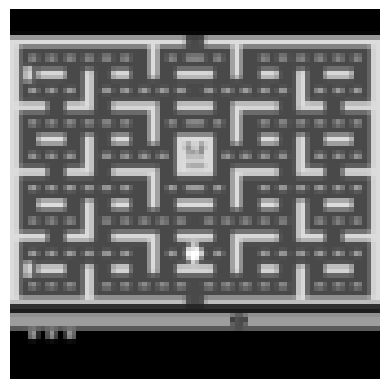

In [4]:
p_frame = preprocess_and_resize(frame)
plt.imshow(p_frame, cmap='gray')
plt.axis('off')
p_frame.shape

In [5]:
stacked_state, stacked_frames = stack_frames(deque(), frame, True)
stacked_state.shape

(4, 84, 84)

In [6]:
class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 1.0  # no-op, but makes intent explicit

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def size(self):
        return len(self.buffer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

def epsilon_greedy_action_selection(state, policy_net, epsilon, num_actions):
    if random.random() < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state)
        return q_values.argmax().item()

In [8]:
env = gym.make("ALE/Pacman-v5", render_mode="rgb_array", full_action_space=False,frameskip=4)
frame, info= env.reset()

In [9]:
import copy 
num_actions = env.action_space.n
q_net = DQN(input_channels=4, num_actions=num_actions)
# Assuming q_net is your main Q-network
target_net = copy.deepcopy(q_net)
target_net.eval()  # Target net is only used for inference


# Move networks to device first
q_net.to(device)
target_net.to(device)

# state, stacked_frames = stack_frames(None, frame, True)
# state_tensor = torch.from_numpy(state).unsqueeze(0)  # (1, 4, 84, 84)
# state_tensor = state_tensor.float()

# with torch.no_grad():
#     q_values = q_net(state_tensor)

# print(q_values.shape)


DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [10]:
episodes = 2500
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.1
gamma = 0.99
lr = 0.00025
buffer_size=1000000
target_update_freq = 1000  # update target net every 1000 steps

optimizer = optim.Adam(q_net.parameters(), lr=lr)
buffer = ReplayBuffer(buffer_size=10000)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange

writer = SummaryWriter(log_dir="runs/pacman_dqn")
global_step = 0
loss_ma = 0  # moving average of loss
# assign tqdm object
pbar = trange(episodes, desc="Episodes", unit="ep", leave=False)
for episode in pbar:
    frame, info = env.reset()
    state, stacked_frames = stack_frames(None, frame, True)
    done = False
    total_reward = 0
    step = 0

    while not done:
        action = epsilon_greedy_action_selection(state, q_net, epsilon, num_actions)

        next_frame, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state, stacked_frames = stack_frames(stacked_frames, next_frame, False)

        # Replay buffer
        experience = (state, action, reward, next_state, done)
        buffer.add(experience=experience)

        # --- TD loss step ---
        if buffer.size() > batch_size:
            batch = buffer.sample(batch_size)

            states = torch.FloatTensor(np.array([exp[0] for exp in batch])).to(device)
            actions = torch.LongTensor(np.array([exp[1] for exp in batch])).to(device)
            rewards = torch.FloatTensor(np.array([exp[2] for exp in batch])).to(device)
            next_states = torch.FloatTensor(np.array([exp[3] for exp in batch])).to(device)
            dones = torch.FloatTensor([float(exp[4]) for exp in batch]).to(device)

            # Current Q-values
            q_values_all = q_net(states)
            q_values = q_values_all.gather(1, actions.unsqueeze(1)).squeeze(1)

            # Target Q-values
            with torch.no_grad():
                next_q_values = target_net(next_states)
                max_next_q_values, _ = next_q_values.max(dim=1)
                target = rewards + gamma * max_next_q_values * (1 - dones)

            # Loss
            loss = F.mse_loss(q_values, target)

            # Backprop
            optimizer.zero_grad()
            loss.backward()

            # Optional: gradient norm
            grad_norm = 0
            for param in q_net.parameters():
                if param.grad is not None:
                    grad_norm += param.grad.data.norm(2).item() ** 2
            grad_norm = grad_norm ** 0.5

            optimizer.step()

            # Moving average of loss
            loss_ma = 0.99 * loss_ma + 0.01 * loss.item()

            # --- TensorBoard logging ---
            writer.add_scalar("Loss/td_loss", loss.item(), global_step)
            writer.add_scalar("Loss/td_loss_ma", loss_ma, global_step)
            writer.add_scalar("QValues/max_q", q_values.max().item(), global_step)
            writer.add_scalar("QValues/mean_q", q_values.mean().item(), global_step)
            writer.add_scalar("QValues/target_max", max_next_q_values.max().item(), global_step)
            writer.add_scalar("Rewards/mean_reward", rewards.mean().item(), global_step)
            writer.add_scalar("Gradients/norm", grad_norm, global_step)
            writer.add_scalar("Epsilon/value", epsilon, global_step)
            writer.add_scalar("QValues/target_mean", target.mean().item(), global_step)



            global_step += 1
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(q_net.state_dict())

        # -------------------

        state = next_state
        total_reward += reward
        step += 1

    # Log total reward and episode length
    writer.add_scalar("Rewards/total_reward", total_reward, episode)
    writer.add_scalar("Steps/episode_length", step, episode)

    # Optional: decay epsilon here
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Dynamically update metrics inline
    pbar.set_postfix({
        "Reward": total_reward,
        "Steps": step,
        "Epsilon": f"{epsilon:.3f}"
    })


writer.close()


Episodes:  15%|█▍        | 367/2500 [9:43:35<7:03:19, 11.91s/ep, Reward=24, Steps=432, Epsilon=0.159]     